In [1]:
"""Predict the price of the Uber ride from a given pickup point to the agreed drop-off
location. Perform following tasks:
1. Pre-process the dataset.
2. Identify outliers.
3. Check the correlation.
4. Implement linear regression and ridge, Lasso regression models.
5. Evaluate the models and compare their respective scores like R2, RMSE, etc."""

'Predict the price of the Uber ride from a given pickup point to the agreed drop-off\nlocation. Perform following tasks:\n1. Pre-process the dataset.\n2. Identify outliers.\n3. Check the correlation.\n4. Implement linear regression and ridge, Lasso regression models.\n5. Evaluate the models and compare their respective scores like R2, RMSE, etc.'

In [2]:
# !pip install pandas numpy matplotlib seaborn scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer

In [3]:
df=pd.read_csv('Dataset/uber.csv')

In [4]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [5]:
# Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0', 'key', 'pickup_datetime'])

In [6]:
# Handle missing values
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [7]:
# Basic data cleaning
df_clean = df_imputed[(df_imputed['fare_amount'] > 0) &
                    (df_imputed['passenger_count'] >= 1) &
                    (df_imputed['passenger_count'] <= 6)].copy()

lat_bounds = (-90, 90)
lon_bounds = (-180, 180)

df_clean = df_clean[df_clean['pickup_latitude'].between(*lat_bounds) &
                     df_clean['dropoff_latitude'].between(*lat_bounds) &
                     df_clean['pickup_longitude'].between(*lon_bounds) &
                     df_clean['dropoff_longitude'].between(*lon_bounds)].copy()

print(f"Rows after basic cleaning: {df_clean.shape[0]}")

Rows after basic cleaning: 199256


In [8]:
# Identify outliers in fare_amount using IQR
Q1 = df_clean['fare_amount'].quantile(0.25)
Q3 = df_clean['fare_amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = (df_clean['fare_amount'] < lower_bound) | (df_clean['fare_amount'] > upper_bound)
outliers_count = outlier_mask.sum()
print(f"Fare amount outliers detected: {outliers_count}")

df_no_outliers = df_clean.loc[~outlier_mask].copy()
print(f"Rows after removing outliers: {df_no_outliers.shape[0]}")

Fare amount outliers detected: 17120
Rows after removing outliers: 182136


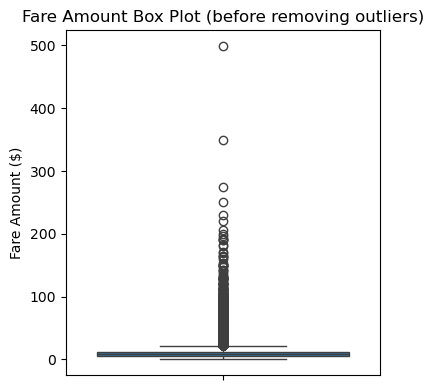

In [9]:
# Box plot to visualize fare_amount outliers
plt.figure(figsize=(4, 4))
sns.boxplot(y=df_clean['fare_amount'])
plt.title('Fare Amount Box Plot (before removing outliers)')
plt.ylabel('Fare Amount ($)')
plt.tight_layout()
plt.show()

In [10]:
# Correlation matrix after cleaning
corr_matrix = df_no_outliers.corr()
corr_matrix

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
fare_amount,1.000000,0.000134,-0.000590,-9.634702e-04,0.000544,1.222314e-02
pickup_longitude,0.000134,1.000000,-0.980169,9.550712e-01,-0.942984,-7.387182e-04
pickup_latitude,-0.000590,-0.980169,1.000000,-9.426733e-01,0.962609,-8.007080e-04
dropoff_longitude,-0.000963,0.955071,-0.942673,1.000000e+00,-0.980724,-8.524099e-07
dropoff_latitude,0.000544,-0.942984,0.962609,-9.807235e-01,1.000000,-1.983893e-03
passenger_count,0.012223,-0.000739,-0.000801,-8.524099e-07,-0.001984,1.000000e+00


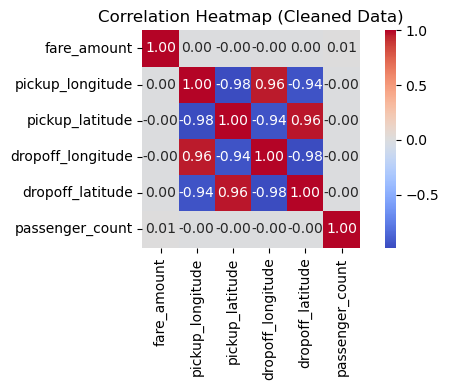

In [11]:
# Heatmap for correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap (Cleaned Data)')
plt.tight_layout()
plt.show()

In [12]:
# Split the data into features (X) and target (y) after cleaning
X = df_no_outliers.drop(columns=['fare_amount'])
y = df_no_outliers['fare_amount']

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Standardize the features (scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# Implement Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

In [16]:
# Implement Ridge Regression
ridge_model = Ridge(alpha=1.0)  
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

In [17]:
# Implement Lasso Regression
lasso_model = Lasso(alpha=0.1)  
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

In [18]:
# Evaluate the models
def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} - R2 Score: {r2:.4f}, RMSE: {rmse:.2f}")
    return {"Model": model_name, "R2": r2, "RMSE": rmse}

In [19]:
results = []
results.append(evaluate_model(y_test, y_pred_lr, "Linear Regression"))
results.append(evaluate_model(y_test, y_pred_ridge, "Ridge Regression"))
results.append(evaluate_model(y_test, y_pred_lasso, "Lasso Regression"))
results_df = pd.DataFrame(results)
results_df

Linear Regression - R2 Score: 0.0001, RMSE: 4.12
Ridge Regression - R2 Score: 0.0001, RMSE: 4.12
Lasso Regression - R2 Score: -0.0000, RMSE: 4.13


,Model,R2,RMSE
0,Linear Regression,0.000139,4.124638
1,Ridge Regression,0.000139,4.124638
2,Lasso Regression,-0.000046,4.125021
